# ✅ Сравним собственную реализацию дерева с scikit-learn

## ⭐ Импорты

In [1]:
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as tree_sk
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from upninja.models.Trees.DecisionTreeClassifier import DecisionTreeClassifier as tree_my

/Users/romanseleznyov/anaconda3/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
SEED = 8

## ⭐ Подготовим данные

In [3]:
dataset = pd.read_csv('data/breast-cancer.csv')
dataset.drop('id', axis=1, inplace=True)
dataset['diagnosis'] = (dataset['diagnosis'] == 'M').astype(int)

cor_target = abs(dataset.corr()['diagnosis'])
relevant_features = cor_target[cor_target>0.25]
names = [index for index, value in relevant_features.items()]
names.remove('diagnosis')

X = dataset[names].values
y = dataset['diagnosis'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

## ⭐ Собственная реализация

In [4]:

my_tree = tree_my(min_samples=10,
                  max_depth=5,
                  criterion='entropy'
                 )

start_time = time()
my_tree.fit(X_train, y_train)
end_time = time()
pred = my_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  1.7061851024627686  (seconds)
🎯Accuracy:  0.9385964912280702


## ⭐ Scikit-learn

In [5]:
sk_tree = tree_sk(min_samples_leaf=10,
                  max_depth=5,
                  criterion='entropy'
                 )

start_time = time()
sk_tree.fit(X_train, y_train)
end_time = time()
pred = sk_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  0.0024590492248535156  (seconds)
🎯Accuracy:  0.9473684210526315


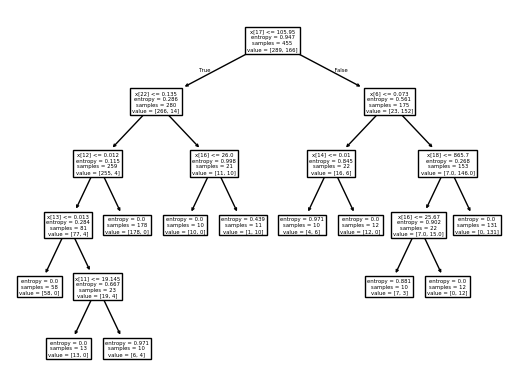

In [6]:
dt_plt = plot_tree(sk_tree)

# ✅ Протестируем собственную реализацию uplift дерева

## ⭐ Импорты

In [1]:
import numpy as np
from sklift.datasets import fetch_hillstrom
from sklift.models import SoloModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from upninja.models.Trees.UpliftTreeClassifier import UpliftTreeClassifier

import matplotlib.pyplot as plt

/Users/romanseleznyov/anaconda3/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
data = fetch_hillstrom(target_col='visit')
df = data.data
X, y, w = df, data.target, data.treatment

# Hillstrom: treatment — 'Mens E-Mail', 'Womens E-Mail' -> объединим в бинарный treatment
w = (w != 'No E-Mail').astype(int)  # 1 — получили email, 0 — нет

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=42
)

num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train = X_train[num_cols].values
X_test = X_test[num_cols].values

In [3]:
%%time

uplift_tree = UpliftTreeClassifier(
    min_samples=200,
    max_depth=4,
    criterion='uplift',
    min_samples_treatment=10
)

uplift_tree.fit(X_train, y_train, w_train)
uplift_pred = uplift_tree.predict(X_test)
print('UpliftTree: средний uplift на тесте =', uplift_pred.mean())

UpliftTree: средний uplift на тесте = 0.05922637294628071
CPU times: user 1min 21s, sys: 1.22 s, total: 1min 22s
Wall time: 1min 23s


In [4]:
%%time

sm = SoloModel(RandomForestClassifier(n_estimators=1, random_state=42))
sm.fit(X_train, y_train, w_train)
sm_pred = sm.predict(X_test)
print('SoloModel (RF): средний uplift на тесте =', sm_pred.mean())

SoloModel (RF): средний uplift на тесте = 0.05270390815954747
CPU times: user 28.2 ms, sys: 1.39 ms, total: 29.6 ms
Wall time: 29 ms


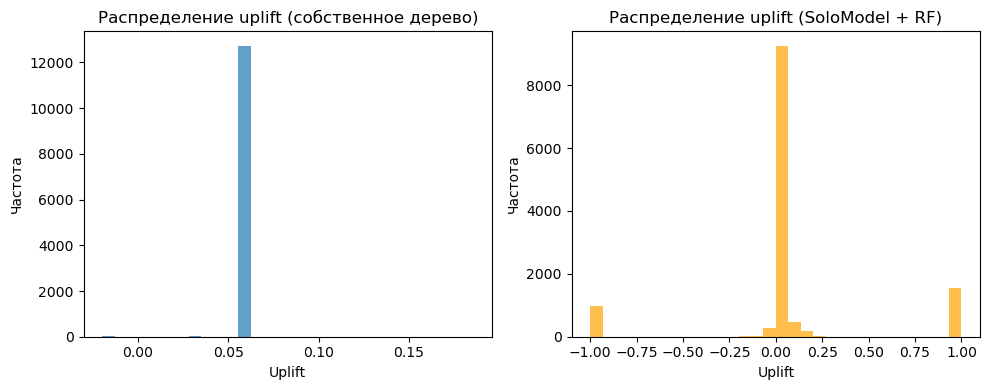

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(uplift_pred, bins=30, alpha=0.7, label='UpliftTree')
plt.title('Распределение uplift (собственное дерево)')
plt.xlabel('Uplift')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(sm_pred, bins=30, alpha=0.7, color='orange', label='SoloModel')
plt.title('Распределение uplift (SoloModel + RF)')
plt.xlabel('Uplift')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()